# Imports

In [1206]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '12'

import sys
sys.path.append('../code')
import utils

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_yearly
py.init_notebook_mode()

pd.plotting.register_matplotlib_converters()
from calendar import day_abbr, month_abbr, mdays
import holidays

from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew

# Data Loading and Cleaning

In [1121]:
# Read csv with total net sales daily
df = pd.read_csv('../data/net_sales_total.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.rename(columns={'date':'datetime'})
df = df.set_index('datetime')

In [1122]:
# Read csv with daily weather
weather_df = pd.read_csv('../data/dark_sky_api.csv')
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df = weather_df.rename(columns={'time':'datetime'})
weather_df = weather_df.set_index('datetime')

# Merge both dataframes
df = df.merge(weather_df, on='datetime')

# Set Freq as 'D'
df = df.asfreq('D')

In [1123]:
# Select features
df = df[['total','icon','temperatureHigh','temperatureLow','precipIntensityMax']]

# Create new feature
df['tempAvg'] = df.loc[: , "temperatureHigh":"temperatureLow"].mean(axis=1)

# Drop features
df.drop(['temperatureHigh', 'temperatureLow'], axis=1, inplace=True)

In [1124]:
## Visual Check for duplicates
# df[df.index.duplicated(keep=False)]

In [1125]:
## Visual check for nan values
# nans = lambda df: df[df.isnull().any(axis=1)]
# nans(df)

In [1126]:
# Fill NaN values with 'partly-cloudy-day'
df = df.fillna('partly-cloudy-day')

In [1127]:
df.reset_index(inplace=True)
df = df.rename(columns={'date':'datetime', 'total':'y'})

### Load weather 2020 Exo

In [1128]:
# Read csv with daily weather
weather2020_df = pd.read_csv('../data/dark_sky_api_2020.csv')
weather2020_df = weather2020_df.drop(columns=['Unnamed: 0'])
weather2020_df['time'] = pd.to_datetime(weather2020_df['time'])
weather2020_df = weather2020_df.rename(columns={'time':'datetime'})
# weather2020_df = weather2020_df.set_index('datetime')

# Select features
weather2020_df = weather2020_df[['datetime','icon','temperatureHigh','temperatureLow','precipIntensityMax']]

# Create new feature
weather2020_df['tempAvg'] = weather2020_df.loc[: , "temperatureHigh":"temperatureLow"].mean(axis=1)

# Drop features
weather2020_df.drop(['temperatureHigh', 'temperatureLow'], axis=1, inplace=True)

In [1129]:
weather2020_df

datetime               icon  precipIntensityMax  tempAvg
0   2020-01-01          clear-day              0.0019   33.805
1   2020-01-02          clear-day              0.0017   45.455
2   2020-01-03               rain              0.0147   46.600
3   2020-01-04               rain              0.0641   44.290
4   2020-01-05               rain              0.0124   37.095
..         ...                ...                 ...      ...
363 2020-12-29  partly-cloudy-day              0.0090   35.175
364 2020-12-30  partly-cloudy-day              0.0090   34.975
365 2020-12-31  partly-cloudy-day              0.0089   34.775
366 2021-01-01  partly-cloudy-day              0.0089   34.590
367 2021-01-02  partly-cloudy-day              0.0088   34.400

[368 rows x 4 columns]

# Create Holiday DataFrame

In [1130]:
holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

In [1131]:
ldates = []
lnames = []
for date, name in sorted(holidays.PE(years=np.arange(2015, 2019 + 1)).items()):
    if 'Independence Day' in name:
        ldates.append(date)
        lnames.append(name)

In [1132]:
ldates = np.array(ldates)
lnames = np.array(lnames)

holidays_df.loc[:,'ds'] = ldates
holidays_df.loc[:,'holiday'] = lnames

In [1133]:
holidays_df.holiday.unique()

array(['Día de la Independencia [Independence Day]'], dtype=object)

In [1134]:
holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply \
(lambda x : x.replace('Día de la Independencia [Independence Day]','Peruvian Independence Day'))

In [1135]:
holidays_df.holiday.unique()

array(['Peruvian Independence Day'], dtype=object)

# Prophet Modeling No Exogenous Vars

In [925]:
data = df[['datetime','y']]
data = data.set_index('datetime')

In [926]:
##########
data1 = data.reset_index()
data1 = data1.rename(columns={'datetime':'ds'})
data1

ds        y
0    2015-01-01  2249.22
1    2015-01-02  1682.68
2    2015-01-03  2550.18
3    2015-01-04  1964.54
4    2015-01-05  1029.82
...         ...      ...
1821 2019-12-27  2325.50
1822 2019-12-28  3277.75
1823 2019-12-29  3919.75
1824 2019-12-30  2041.50
1825 2019-12-31  5200.25

[1826 rows x 2 columns]

In [890]:
data_train, data_test = utils.prepare_data(data, 2019)

In [891]:
data_train.tail()

ds        y
1456 2018-12-27  2271.50
1457 2018-12-28  2288.00
1458 2018-12-29  3417.25
1459 2018-12-30  3589.25
1460 2018-12-31  4456.75

In [892]:
data_test.head()

ds        y
0 2019-01-01  3591.50
1 2019-01-02  1247.75
2 2019-01-03  1198.50
3 2019-01-04  1830.00
4 2019-01-05  3188.00

In [958]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, \
            seasonality_mode='additive', \
#             yearly_seasonality=False, \
            weekly_seasonality=True, \
            daily_seasonality=False)
m.add_country_holidays(country_name='US')

In [894]:
%%time
m.fit(data_train)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Wall time: 1min 12s


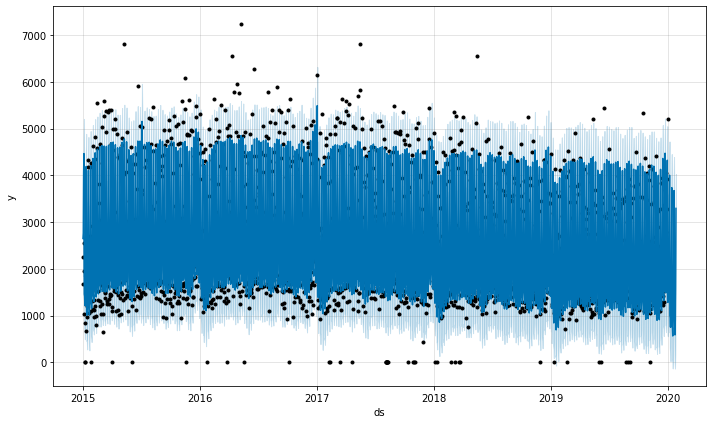

In [932]:
##########
fig1 = m.plot(forecast)

In [631]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [632]:
forecast = m.predict(future)

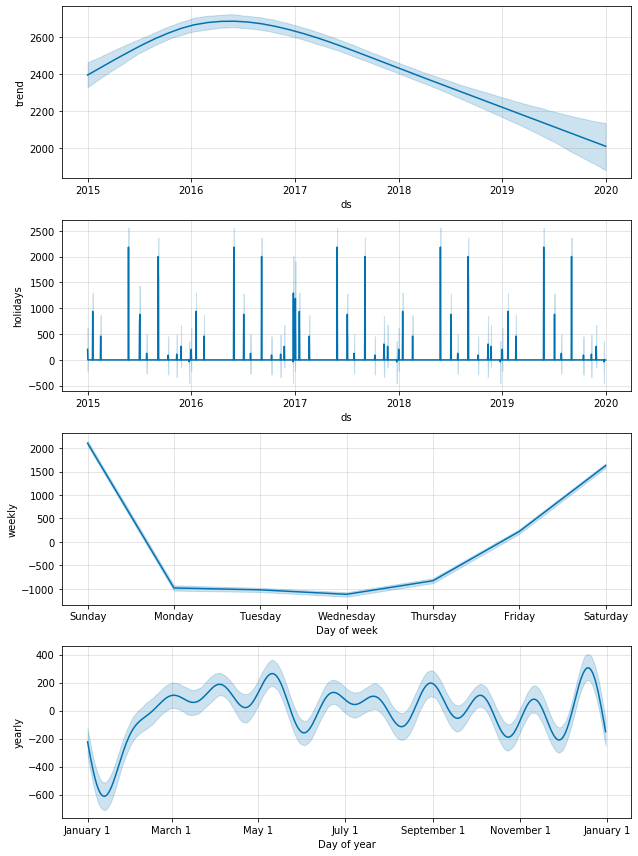

In [633]:
f = m.plot_components(forecast)

In [634]:
verif = utils.make_verif(forecast, data_train, data_test)

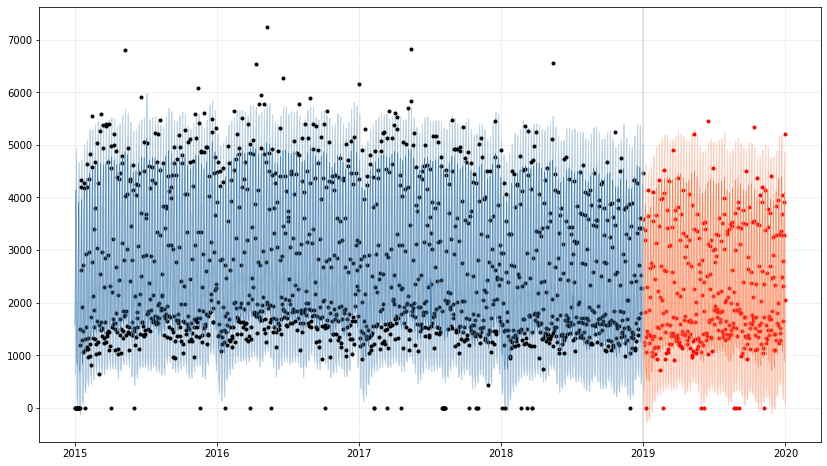

In [635]:
f = utils.plot_verif(verif, year=2019)

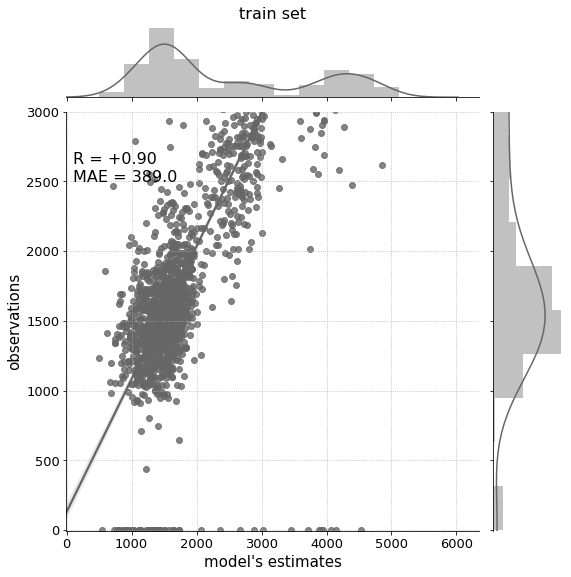

In [636]:
utils.plot_joint_plot(verif.loc[:'2019',:], title='train set', fname='train_set_joint_plot_no_climate')

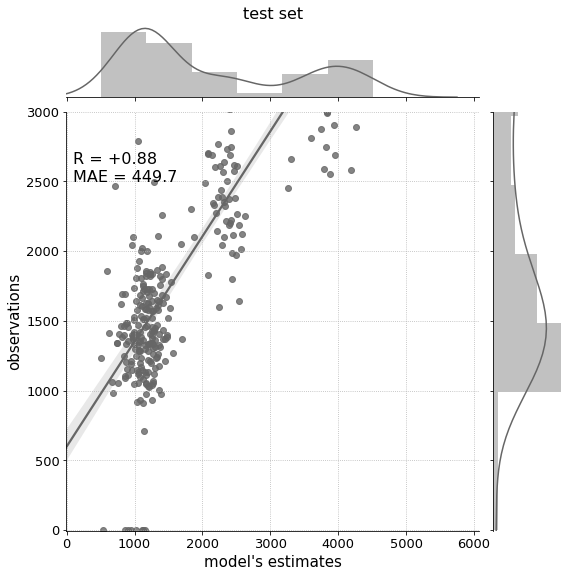

In [637]:
utils.plot_joint_plot(verif.loc['2019':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [638]:
verif.loc['2019':,['y','yhat']].corr()

y      yhat
y     1.000000  0.879001
yhat  0.879001  1.000000

In [639]:
MAE(verif.loc['2019':,'y'].values, verif.loc['2019':,'yhat'].values)

449.71614158968856

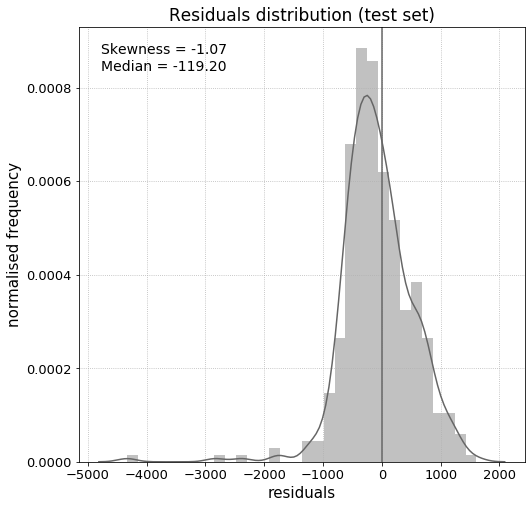

In [640]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot((verif.loc['2019':,'yhat'] - verif.loc['2019':,'y']), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(verif.loc['2019':,'yhat'] - verif.loc['2019':,'y']), (verif.loc['2019':,'yhat'] - verif.loc['2019':,'y']).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/residuals_distribution_test_set_no_climate.{ext}', dpi=200)

# Adding Weather to Prophet Model

In [700]:
temp = df[['datetime','tempAvg']]
temp = temp.set_index('datetime')

precip = df[['datetime','precipIntensityMax']]
precip = precip.set_index('datetime')

weather = df[['datetime','icon']]
weather = weather.set_index('datetime')

In [701]:
data_with_regressors = utils.add_regressor(data, temp, varname='tempAvg')

In [702]:
data_with_regressors = utils.add_regressor(data_with_regressors, precip, varname='precipIntensityMax')

In [703]:
# data_with_regressors = utils.add_regressor(data_with_regressors, weather, varname='icon')

In [704]:
# data_with_regressors = pd.get_dummies(data_with_regressors,'icon', drop_first=True)

In [705]:
data_train, data_test = utils.prepare_data(data_with_regressors, 2019)

In [706]:
data_with_regressors

y  tempAvg  precipIntensityMax
datetime                                        
2015-01-01     0.00   36.325              0.0000
2015-01-02     0.00   35.895              0.0000
2015-01-03     0.00   38.395              0.1062
2015-01-04     0.00   46.605              0.1195
2015-01-05     0.00   29.050              0.0000
...             ...      ...                 ...
2019-12-27  2325.50   46.140              0.0015
2019-12-28  3277.75   43.485              0.0020
2019-12-29  3919.75   40.895              0.0485
2019-12-30  2041.50   39.440              0.0734
2019-12-31  5200.25   39.725              0.0015

[1826 rows x 3 columns]

In [707]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, \
            seasonality_mode='additive', \
#             yearly_seasonality=False, \
            weekly_seasonality=True, \
            daily_seasonality=False)
m.add_country_holidays(country_name='US')

In [708]:
m.add_regressor('tempAvg', prior_scale=0.5, mode='additive')
m.add_regressor('precipIntensityMax', prior_scale=0.5, mode='additive')
# m.add_regressor('icon_cloudy', prior_scale=0.5, mode='additive')
# m.add_regressor('icon_fog', prior_scale=0.5, mode='additive')
# m.add_regressor('icon_partly-cloudy-day', prior_scale=0.5, mode='additive')
# m.add_regressor('icon_rain', prior_scale=0.5, mode='additive')
# m.add_regressor('icon_sleet', prior_scale=0.5, mode='additive')
# m.add_regressor('icon_snow', prior_scale=0.5, mode='additive')
# m.add_regressor('icon_wind', prior_scale=0.5, mode='additive')

In [709]:
%%time
m.fit(data_train)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Wall time: 1min 21s


In [710]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [711]:
futures = utils.add_regressor_to_future(future, [temp, precip])

In [712]:
futures.head()

ds  tempAvg  precipIntensityMax
0 2015-01-01   36.325              0.0000
1 2015-01-02   35.895              0.0000
2 2015-01-03   38.395              0.1062
3 2015-01-04   46.605              0.1195
4 2015-01-05   29.050              0.0000

In [713]:
forecast = m.predict(futures)

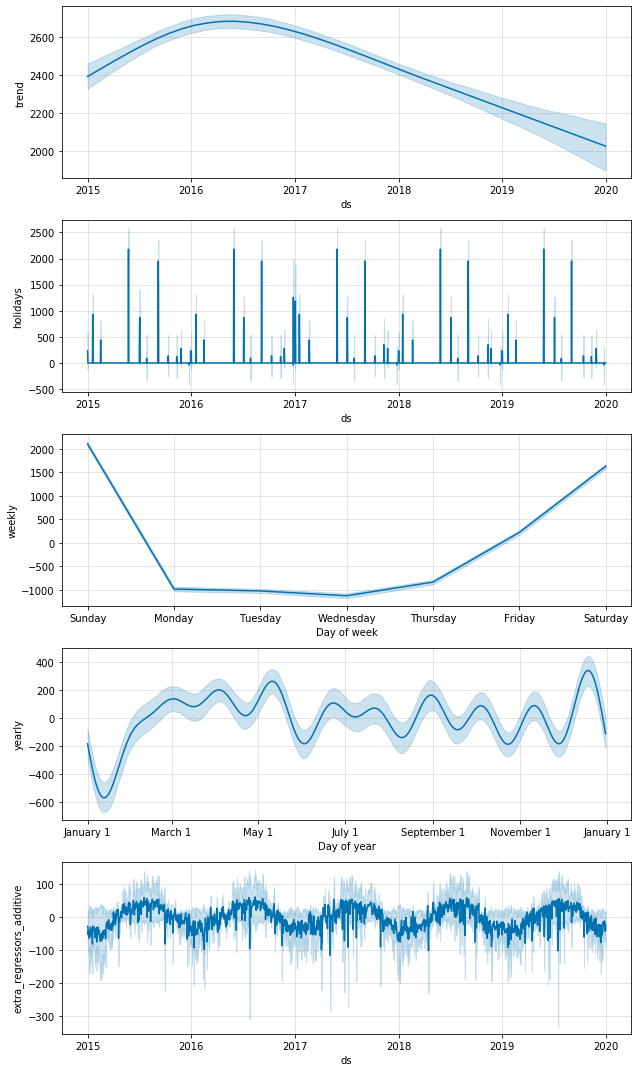

In [714]:
f = m.plot_components(forecast)

In [715]:
verif = utils.make_verif(forecast, data_train, data_test)

In [716]:
verif.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
ds                                                                          
2015-01-01 2015-01-01  2392.475086   729.086461  2429.694858  2326.404944   
2015-01-02 2015-01-02  2393.353869  1554.191667  3158.516919  2327.499247   
2015-01-03 2015-01-03  2394.232652  2894.046710  4465.090594  2328.752377   
2015-01-04 2015-01-04  2395.111435  3367.024945  4986.337471  2330.005506   
2015-01-05 2015-01-05  2395.990217   214.848781  1727.182702  2330.957898   

            trend_upper  Christmas Day  Christmas Day_lower  \
ds                                                            
2015-01-01  2462.544314            0.0                  0.0   
2015-01-02  2463.214896            0.0                  0.0   
2015-01-03  2463.885478            0.0                  0.0   
2015-01-04  2464.554815            0.0                  0.0   
2015-01-05  2465.207495            0.0                  0.0   

            Christmas Day_upper  Christmas Day (Observed)  ...  weekly_lower  \
ds                                                         ...                 
2015-01-01                  0.0                       0.0  ...   -881.679622   
2015-01-02                  0.0                       0.0  ...    170.656070   
2015-01-03                  0.0                       0.0  ...   1582.385730   
2015-01-04                  0.0                       0.0  ...   2056.337192   
2015-01-05                  0.0                       0.0  ...  -1029.666042   

            weekly_upper      yearly  yearly_lower  yearly_upper  \
ds                                                                 
2015-01-01   -786.237716 -156.758456   -266.141353    -46.115938   
2015-01-02    273.439022 -213.981224   -320.786129   -103.768893   
2015-01-03   1677.287284 -269.391468   -376.539298   -161.800900   
2015-01-04   2150.288660 -322.086338   -427.071661   -212.197310   
2015-01-05   -931.446828 -371.234813   -477.713214   -265.924974   

            multiplicative_terms  multiplicative_terms_lower  \
ds                                                             
2015-01-01                   0.0                         0.0   
2015-01-02                   0.0                         0.0   
2015-01-03                   0.0                         0.0   
2015-01-04                   0.0                         0.0   
2015-01-05                   0.0                         0.0   

            multiplicative_terms_upper         yhat    y  
ds                                                        
2015-01-01                         0.0  1608.071522  0.0  
2015-01-02                         0.0  2373.145348  0.0  
2015-01-03                         0.0  3702.344668  0.0  
2015-01-04                         0.0  4135.182988  0.0  
2015-01-05                         0.0  1003.696874  0.0  

[5 rows x 77 columns]

In [721]:
verif.loc[:,'yhat'] = verif.yhat.clip(lower=0)

In [722]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip(lower=0)

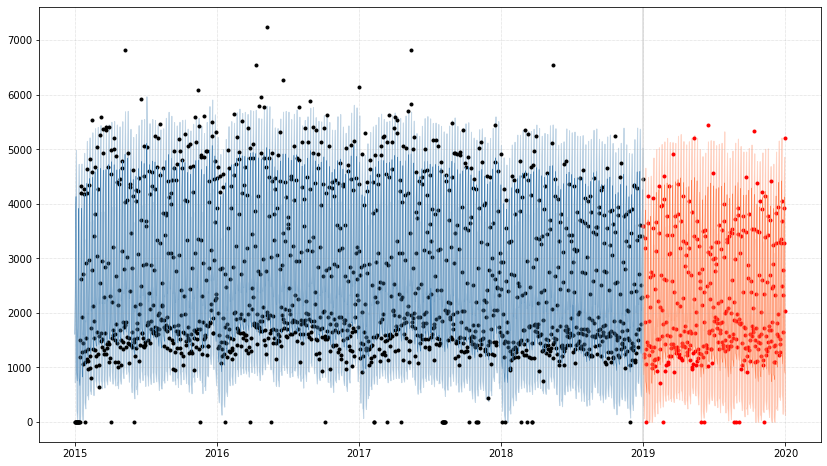

In [723]:
f =  utils.plot_verif(verif, 2019)

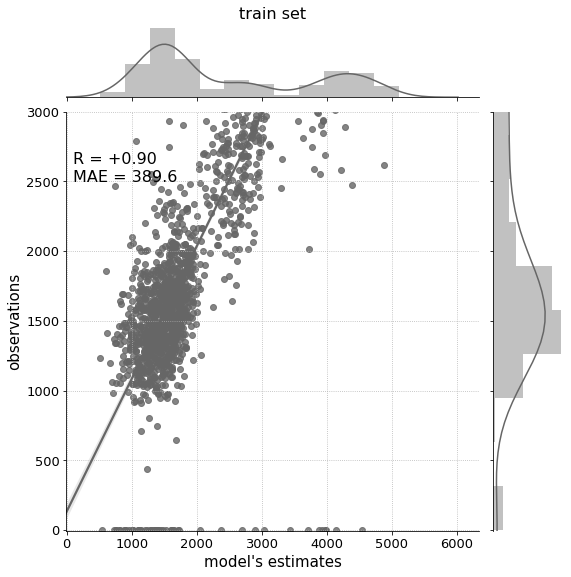

In [724]:
utils.plot_joint_plot(verif.loc[:'2019',:], title='train set', fname='train_set_joint_plot_climate')

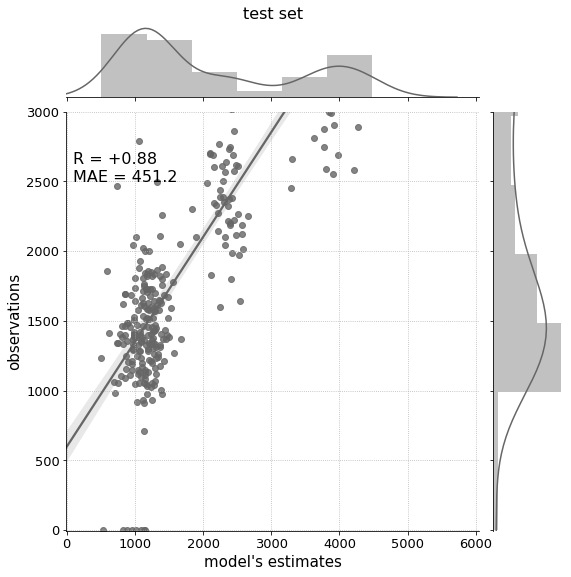

In [725]:
utils.plot_joint_plot(verif.loc['2019':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [726]:
residuals = verif.loc['2019':,'yhat'] - verif.loc['2019':,'y']

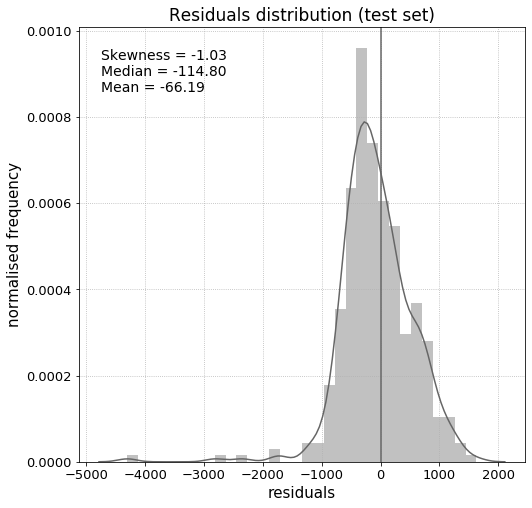

In [727]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals), residuals.median(), residuals.mean()), \
        fontsize=14, transform=ax.transAxes)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/residuals_distribution_test_set_climate.{ext}', dpi=200)

# Adding Weather with Exogenous Variables

In [769]:
temp = df[['datetime','tempAvg']]
temp = temp.set_index('datetime')

precip = df[['datetime','precipIntensityMax']]
precip = precip.set_index('datetime')

weather = df[['datetime','icon']]
weather = weather.set_index('datetime')

In [770]:
data_with_regressors = utils.add_regressor(data, temp, varname='tempAvg')

In [771]:
data_with_regressors = utils.add_regressor(data_with_regressors, precip, varname='precipIntensityMax')

In [772]:
data_with_regressors = utils.add_regressor(data_with_regressors, weather, varname='icon')

In [773]:
data_with_regressors = pd.get_dummies(data_with_regressors,'icon', drop_first=True)

In [774]:
icon_cloudy = data_with_regressors[['icon_cloudy']]

icon_fog = data_with_regressors[['icon_fog']]

partly_cloudy = data_with_regressors[['icon_partly-cloudy-day']]

icon_rain = data_with_regressors[['icon_rain']]

icon_sleet = data_with_regressors[['icon_sleet']]

icon_snow = data_with_regressors[['icon_snow']]

icon_wind = data_with_regressors[['icon_wind']]

In [775]:
data_train, data_test = utils.prepare_data(data_with_regressors, 2019)

In [776]:
data_with_regressors

y  tempAvg  precipIntensityMax  icon_cloudy  icon_fog  \
datetime                                                                  
2015-01-01     0.00   36.325              0.0000            0         0   
2015-01-02     0.00   35.895              0.0000            0         0   
2015-01-03     0.00   38.395              0.1062            0         0   
2015-01-04     0.00   46.605              0.1195            0         0   
2015-01-05     0.00   29.050              0.0000            0         0   
...             ...      ...                 ...          ...       ...   
2019-12-27  2325.50   46.140              0.0015            0         0   
2019-12-28  3277.75   43.485              0.0020            0         0   
2019-12-29  3919.75   40.895              0.0485            0         0   
2019-12-30  2041.50   39.440              0.0734            0         0   
2019-12-31  5200.25   39.725              0.0015            0         0   

            icon_partly-cloudy-day  icon_rain  icon_sleet  icon_snow  \
datetime                                                               
2015-01-01                       0          0           0          0   
2015-01-02                       1          0           0          0   
2015-01-03                       0          1           0          0   
2015-01-04                       0          1           0          0   
2015-01-05                       1          0           0          0   
...                            ...        ...         ...        ...   
2019-12-27                       0          1           0          0   
2019-12-28                       1          0           0          0   
2019-12-29                       0          1           0          0   
2019-12-30                       0          1           0          0   
2019-12-31                       0          1           0          0   

            icon_wind  
datetime               
2015-01-01          0  
2015-01-02          0  
2015-01-03          0  
2015-01-04          0  
2015-01-05          0  
...               ...  
2019-12-27          0  
2019-12-28          0  
2019-12-29          0  
2019-12-30          0  
2019-12-31          0  

[1826 rows x 10 columns]

In [777]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, \
            seasonality_mode='additive', \
#             yearly_seasonality=False, \
            weekly_seasonality=True, \
            daily_seasonality=False)
m.add_country_holidays(country_name='US')

In [778]:
m.add_regressor('tempAvg', prior_scale=0.5, mode='additive')
m.add_regressor('precipIntensityMax', prior_scale=0.5, mode='additive')
m.add_regressor('icon_cloudy', prior_scale=0.5, mode='additive')
m.add_regressor('icon_fog', prior_scale=0.5, mode='additive')
m.add_regressor('icon_partly-cloudy-day', prior_scale=0.5, mode='additive')
m.add_regressor('icon_rain', prior_scale=0.5, mode='additive')
m.add_regressor('icon_sleet', prior_scale=0.5, mode='additive')
m.add_regressor('icon_snow', prior_scale=0.5, mode='additive')
m.add_regressor('icon_wind', prior_scale=0.5, mode='additive')

In [779]:
%%time
m.fit(data_train)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Wall time: 1min 44s


In [780]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [782]:
futures = utils.add_regressor_to_future(future, [temp, precip, icon_cloudy, icon_fog, partly_cloudy, icon_rain, icon_sleet, icon_snow, icon_wind])

In [783]:
futures.head()

ds  tempAvg  precipIntensityMax  icon_cloudy  icon_fog  \
0 2015-01-01   36.325              0.0000            0         0   
1 2015-01-02   35.895              0.0000            0         0   
2 2015-01-03   38.395              0.1062            0         0   
3 2015-01-04   46.605              0.1195            0         0   
4 2015-01-05   29.050              0.0000            0         0   

   icon_partly-cloudy-day  icon_rain  icon_sleet  icon_snow  icon_wind  
0                       0          0           0          0          0  
1                       1          0           0          0          0  
2                       0          1           0          0          0  
3                       0          1           0          0          0  
4                       1          0           0          0          0

In [784]:
forecast = m.predict(futures)

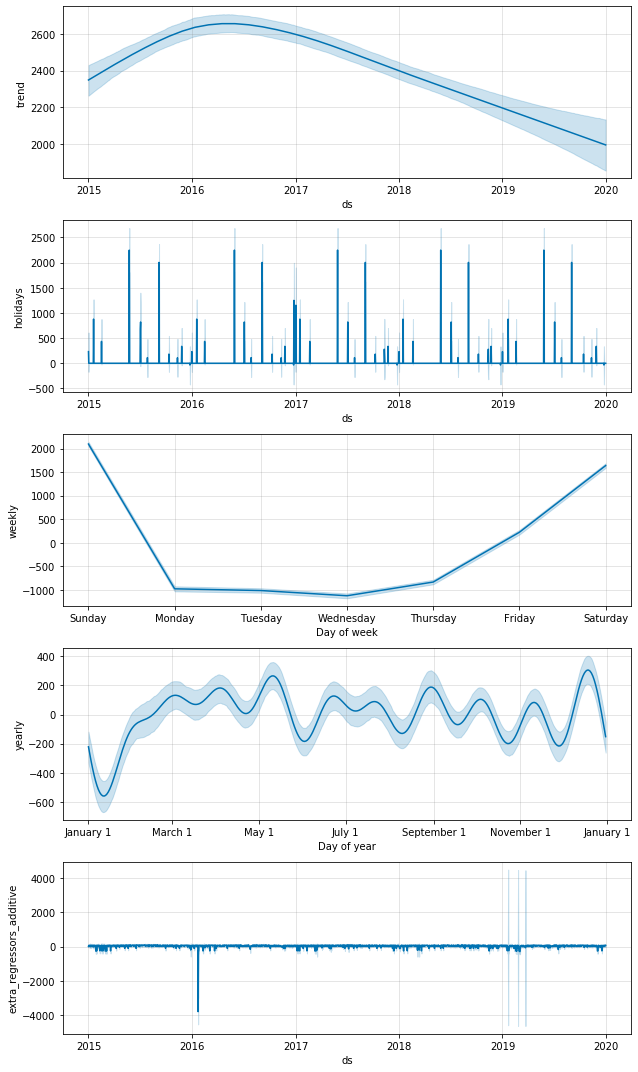

In [785]:
f = m.plot_components(forecast)

In [788]:
verif = utils.make_verif(forecast, data_train, data_test)

In [789]:
verif.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
ds                                                                          
2015-01-01 2015-01-01  2348.877356   658.191909  2435.985888  2263.604351   
2015-01-02 2015-01-02  2349.799445  1610.500349  3187.688547  2264.851718   
2015-01-03 2015-01-03  2350.721534  2914.478597  4483.606330  2266.099085   
2015-01-04 2015-01-04  2351.643623  3372.346516  4902.254746  2267.346452   
2015-01-05 2015-01-05  2352.565713   326.492895  1781.535748  2268.593819   

            trend_upper  Christmas Day  Christmas Day_lower  \
ds                                                            
2015-01-01  2429.899886            0.0                  0.0   
2015-01-02  2430.672863            0.0                  0.0   
2015-01-03  2431.445840            0.0                  0.0   
2015-01-04  2432.218817            0.0                  0.0   
2015-01-05  2432.991794            0.0                  0.0   

            Christmas Day_upper  Christmas Day (Observed)  ...  weekly_lower  \
ds                                                         ...                 
2015-01-01                  0.0                       0.0  ...   -884.051401   
2015-01-02                  0.0                       0.0  ...    174.571608   
2015-01-03                  0.0                       0.0  ...   1590.825035   
2015-01-04                  0.0                       0.0  ...   2054.567859   
2015-01-05                  0.0                       0.0  ...  -1034.327456   

            weekly_upper      yearly  yearly_lower  yearly_upper  \
ds                                                                 
2015-01-01   -787.491737 -194.186423   -301.570962    -91.026299   
2015-01-02    273.070066 -249.243748   -356.887926   -146.191540   
2015-01-03   1688.006889 -302.003780   -411.856641   -193.703537   
2015-01-04   2143.658831 -351.575802   -460.610068   -242.901402   
2015-01-05   -926.595207 -397.152401   -505.057145   -291.382735   

            multiplicative_terms  multiplicative_terms_lower  \
ds                                                             
2015-01-01                   0.0                         0.0   
2015-01-02                   0.0                         0.0   
2015-01-03                   0.0                         0.0   
2015-01-04                   0.0                         0.0   
2015-01-05                   0.0                         0.0   

            multiplicative_terms_upper         yhat    y  
ds                                                        
2015-01-01                         0.0  1554.083204  0.0  
2015-01-02                         0.0  2392.221817  0.0  
2015-01-03                         0.0  3708.616751  0.0  
2015-01-04                         0.0  4114.535232  0.0  
2015-01-05                         0.0  1042.081546  0.0  

[5 rows x 98 columns]

In [790]:
verif.loc[:,'yhat'] = verif.yhat.clip(lower=0)

In [791]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip(lower=0)

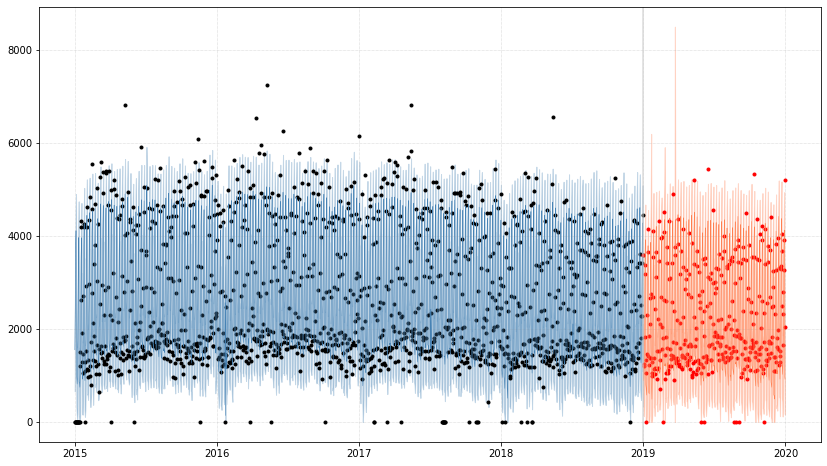

In [792]:
f =  utils.plot_verif(verif, 2019)

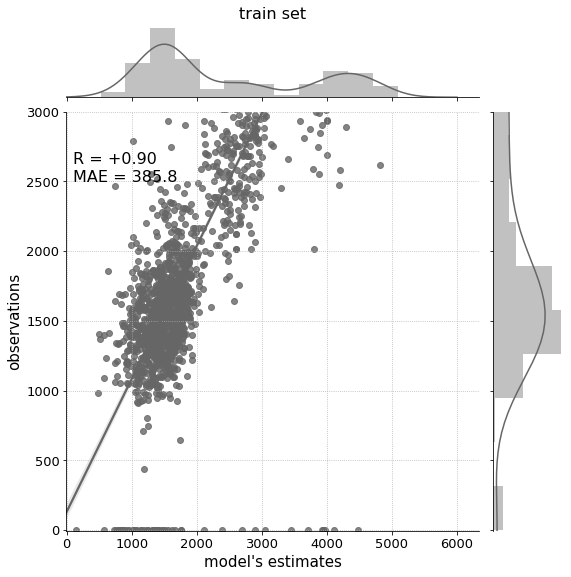

In [793]:
utils.plot_joint_plot(verif.loc[:'2019',:], title='train set', fname='train_set_joint_plot_climate')

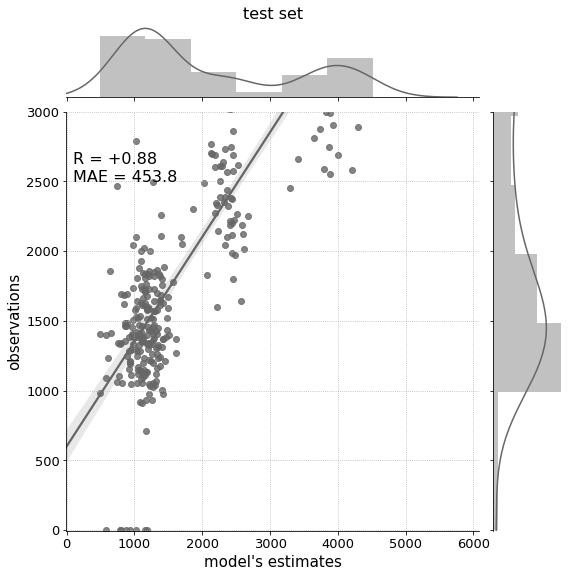

In [794]:
utils.plot_joint_plot(verif.loc['2019':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [795]:
residuals = verif.loc['2019':,'yhat'] - verif.loc['2019':,'y']

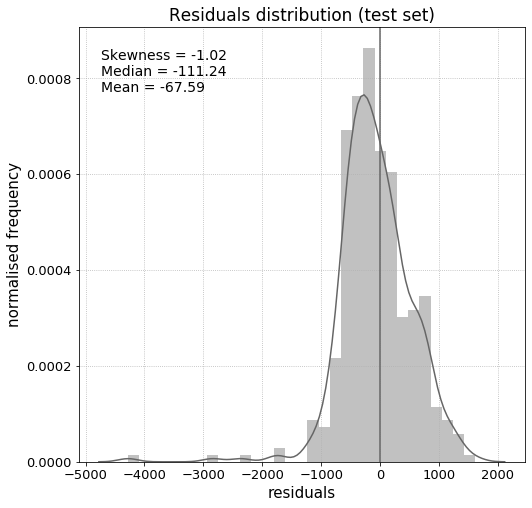

In [796]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals), residuals.median(), residuals.mean()), \
        fontsize=14, transform=ax.transAxes)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/residuals_distribution_test_set_climate.{ext}', dpi=200)

# Final Model Train

In [1136]:
temp = df[['datetime','tempAvg']]
temp = temp.set_index('datetime')

precip = df[['datetime','precipIntensityMax']]
precip = precip.set_index('datetime')

weather = df[['datetime','icon']]
weather = weather.set_index('datetime')

In [1137]:
data_with_regressors = utils.add_regressor(data, temp, varname='tempAvg')

In [1138]:
data_with_regressors = utils.add_regressor(data_with_regressors, precip, varname='precipIntensityMax')

In [1139]:
data_with_regressors = utils.add_regressor(data_with_regressors, weather, varname='icon')

In [1140]:
data_with_regressors = pd.get_dummies(data_with_regressors,'icon', drop_first=True)

In [1141]:
icon_cloudy = data_with_regressors[['icon_cloudy']]

icon_fog = data_with_regressors[['icon_fog']]

partly_cloudy = data_with_regressors[['icon_partly-cloudy-day']]

icon_rain = data_with_regressors[['icon_rain']]

icon_sleet = data_with_regressors[['icon_sleet']]

icon_snow = data_with_regressors[['icon_snow']]

icon_wind = data_with_regressors[['icon_wind']]

In [1093]:
# data_train, data_test = utils.prepare_data(data_with_regressors, 2019)

In [1142]:
data_with_regressors

y  tempAvg  precipIntensityMax  icon_cloudy  icon_fog  \
datetime                                                                  
2015-01-01  2249.22   36.325              0.0000            0         0   
2015-01-02  1682.68   35.895              0.0000            0         0   
2015-01-03  2550.18   38.395              0.1062            0         0   
2015-01-04  1964.54   46.605              0.1195            0         0   
2015-01-05  1029.82   29.050              0.0000            0         0   
...             ...      ...                 ...          ...       ...   
2019-12-27  2325.50   46.140              0.0015            0         0   
2019-12-28  3277.75   43.485              0.0020            0         0   
2019-12-29  3919.75   40.895              0.0485            0         0   
2019-12-30  2041.50   39.440              0.0734            0         0   
2019-12-31  5200.25   39.725              0.0015            0         0   

            icon_partly-cloudy-day  icon_rain  icon_sleet  icon_snow  \
datetime                                                               
2015-01-01                       0          0           0          0   
2015-01-02                       1          0           0          0   
2015-01-03                       0          1           0          0   
2015-01-04                       0          1           0          0   
2015-01-05                       1          0           0          0   
...                            ...        ...         ...        ...   
2019-12-27                       0          1           0          0   
2019-12-28                       1          0           0          0   
2019-12-29                       0          1           0          0   
2019-12-30                       0          1           0          0   
2019-12-31                       0          1           0          0   

            icon_wind  
datetime               
2015-01-01          0  
2015-01-02          0  
2015-01-03          0  
2015-01-04          0  
2015-01-05          0  
...               ...  
2019-12-27          0  
2019-12-28          0  
2019-12-29          0  
2019-12-30          0  
2019-12-31          0  

[1826 rows x 10 columns]

In [1143]:
data_with_regressors = data_with_regressors.reset_index()
data_with_regressors = data_with_regressors.rename(columns={'datetime':'ds'})
data_with_regressors

ds        y  tempAvg  precipIntensityMax  icon_cloudy  icon_fog  \
0    2015-01-01  2249.22   36.325              0.0000            0         0   
1    2015-01-02  1682.68   35.895              0.0000            0         0   
2    2015-01-03  2550.18   38.395              0.1062            0         0   
3    2015-01-04  1964.54   46.605              0.1195            0         0   
4    2015-01-05  1029.82   29.050              0.0000            0         0   
...         ...      ...      ...                 ...          ...       ...   
1821 2019-12-27  2325.50   46.140              0.0015            0         0   
1822 2019-12-28  3277.75   43.485              0.0020            0         0   
1823 2019-12-29  3919.75   40.895              0.0485            0         0   
1824 2019-12-30  2041.50   39.440              0.0734            0         0   
1825 2019-12-31  5200.25   39.725              0.0015            0         0   

      icon_partly-cloudy-day  icon_rain  icon_sleet  icon_snow  icon_wind  
0                          0          0           0          0          0  
1                          1          0           0          0          0  
2                          0          1           0          0          0  
3                          0          1           0          0          0  
4                          1          0           0          0          0  
...                      ...        ...         ...        ...        ...  
1821                       0          1           0          0          0  
1822                       1          0           0          0          0  
1823                       0          1           0          0          0  
1824                       0          1           0          0          0  
1825                       0          1           0          0          0  

[1826 rows x 11 columns]

In [1144]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, \
            seasonality_mode='additive', \
#             yearly_seasonality=False, \
            weekly_seasonality=True, \
            daily_seasonality=False)
m.add_country_holidays(country_name='US')

In [1145]:
m.add_regressor('tempAvg', prior_scale=0.5, mode='additive')
m.add_regressor('precipIntensityMax', prior_scale=0.5, mode='additive')
m.add_regressor('icon_cloudy', prior_scale=0.5, mode='additive')
m.add_regressor('icon_fog', prior_scale=0.5, mode='additive')
m.add_regressor('icon_partly-cloudy-day', prior_scale=0.5, mode='additive')
m.add_regressor('icon_rain', prior_scale=0.5, mode='additive')
m.add_regressor('icon_sleet', prior_scale=0.5, mode='additive')
m.add_regressor('icon_snow', prior_scale=0.5, mode='additive')
m.add_regressor('icon_wind', prior_scale=0.5, mode='additive')

In [1146]:
%%time
m.fit(data_with_regressors)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Wall time: 2min


In [1190]:
future = m.make_future_dataframe(periods=25, freq='1D')

In [1191]:
future.tail()

ds
1846 2020-01-21
1847 2020-01-22
1848 2020-01-23
1849 2020-01-24
1850 2020-01-25

In [1192]:
weather2020_df = pd.get_dummies(weather2020_df,'icon', drop_first=True)

In [1193]:
weather2020_df['icon_fog'] = 0
weather2020_df['icon_sleet'] = 0
weather2020_df['icon_wind'] = 0

In [1194]:
weather2020_df = weather2020_df.rename(columns={'datetime':'ds'})

In [1200]:
pd.concat([future, weather2020_df])

C:\Users\Kenny\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




ds  icon_cloudy  icon_fog  icon_partly-cloudy-day  icon_rain  \
0   2015-01-01          NaN       NaN                     NaN        NaN   
1   2015-01-02          NaN       NaN                     NaN        NaN   
2   2015-01-03          NaN       NaN                     NaN        NaN   
3   2015-01-04          NaN       NaN                     NaN        NaN   
4   2015-01-05          NaN       NaN                     NaN        NaN   
..         ...          ...       ...                     ...        ...   
363 2020-12-29          0.0       0.0                     1.0        0.0   
364 2020-12-30          0.0       0.0                     1.0        0.0   
365 2020-12-31          0.0       0.0                     1.0        0.0   
366 2021-01-01          0.0       0.0                     1.0        0.0   
367 2021-01-02          0.0       0.0                     1.0        0.0   

     icon_sleet  icon_snow  icon_wind  precipIntensityMax  tempAvg  
0           NaN        NaN        NaN                 NaN      NaN  
1           NaN        NaN        NaN                 NaN      NaN  
2           NaN        NaN        NaN                 NaN      NaN  
3           NaN        NaN        NaN                 NaN      NaN  
4           NaN        NaN        NaN                 NaN      NaN  
..          ...        ...        ...                 ...      ...  
363         0.0        0.0        0.0              0.0090   35.175  
364         0.0        0.0        0.0              0.0090   34.975  
365         0.0        0.0        0.0              0.0089   34.775  
366         0.0        0.0        0.0              0.0089   34.590  
367         0.0        0.0        0.0              0.0088   34.400  

[2219 rows x 10 columns]

In [1168]:
future = future.merge(weather2020_df, on='ds')

In [1201]:
future

ds
0    2015-01-01
1    2015-01-02
2    2015-01-03
3    2015-01-04
4    2015-01-05
...         ...
1846 2020-01-21
1847 2020-01-22
1848 2020-01-23
1849 2020-01-24
1850 2020-01-25

[1851 rows x 1 columns]

In [877]:
# futures = utils.add_regressor_to_future(future, [temp, precip, icon_cloudy, icon_fog, partly_cloudy, icon_rain, icon_sleet, icon_snow, icon_wind])

In [880]:
# futures.head()

ds  tempAvg  precipIntensityMax  icon_cloudy  icon_fog  \
0 2015-01-01   36.325              0.0000            0         0   
1 2015-01-02   35.895              0.0000            0         0   
2 2015-01-03   38.395              0.1062            0         0   
3 2015-01-04   46.605              0.1195            0         0   
4 2015-01-05   29.050              0.0000            0         0   

   icon_partly-cloudy-day  icon_rain  icon_sleet  icon_snow  icon_wind  
0                       0          0           0          0          0  
1                       1          0           0          0          0  
2                       0          1           0          0          0  
3                       0          1           0          0          0  
4                       1          0           0          0          0

In [881]:
# forecast = m.predict(futures)

In [1170]:
forecast = m.predict(future)

In [1173]:
forecast[['ds', 'yhat']].head(20)

ds         yhat
0  2020-01-01  1912.823797
1  2020-01-02  1318.385343
2  2020-01-03  2320.172141
3  2020-01-04  3606.974374
4  2020-01-05  4019.432035
5  2020-01-06   753.827822
6  2020-01-07   982.331251
7  2020-01-08   774.952235
8  2020-01-09  1019.879871
9  2020-01-10  2069.740066
10 2020-01-11  3376.922719
11 2020-01-12  3793.123640
12 2020-01-13   833.506412
13 2020-01-14   803.409681
14 2020-01-15   653.431418
15 2020-01-16   932.799435
16 2020-01-17  1905.955609
17 2020-01-18  3020.602008
18 2020-01-19  3750.174381
19 2020-01-20  1400.224900

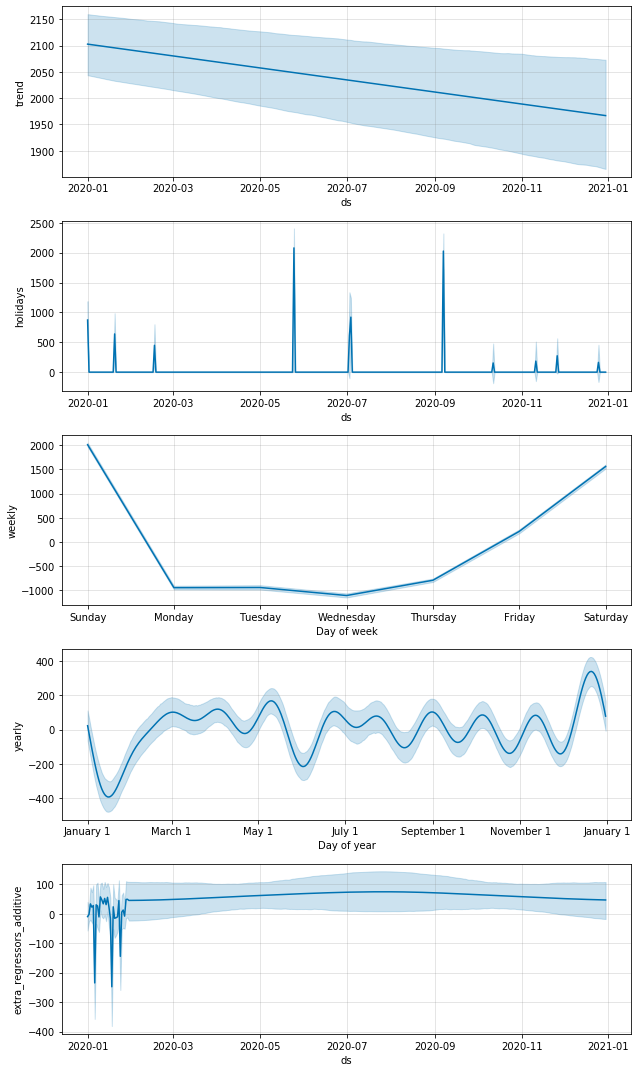

In [1172]:
f = m.plot_components(forecast)

In [1202]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, horizon='90 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 31 forecasts with cutoffs between 2016-01-21 00:00:00 and 2019-10-02 00:00:00
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pyst

horizon            mse        rmse         mae  coverage
0  9 days  312354.944587  558.887238  379.192561  0.874552
1 10 days  313140.908742  559.589947  375.247928  0.881720
2 11 days  246851.771768  496.841798  371.489273  0.863799
3 12 days  218126.106997  467.039727  361.764245  0.878136
4 13 days  221637.090015  470.783485  364.789226  0.874552

In [1209]:
with open('../model/forecast_model.pckl', 'wb') as fout:
    pickle.dump(m, fout)
    
with open('../model/forecast_model.pckl', 'rb') as fin:
    m2 = pickle.load(fin)